In [5]:
#RUN FIRST

curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()



'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
#control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 1 #toolloc_params
vols = 341 #toolloc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

Successfully saved group average for pIPS left fc


Successfully saved group average for pIPS left ppi
Successfully saved group average for pIPS right fc
Successfully saved group average for pIPS right ppi
Successfully saved group average for LO left fc
Successfully saved group average for LO left ppi
Successfully saved group average for LO right fc
Successfully saved group average for LO right ppi
Successfully saved group average for PFS left fc
Successfully saved group average for PFS left ppi
Successfully saved group average for PFS right fc
Successfully saved group average for PFS right ppi
Successfully saved group average for aIPS left fc
Successfully saved group average for aIPS left ppi
Successfully saved group average for aIPS right fc
Successfully saved group average for aIPS right ppi


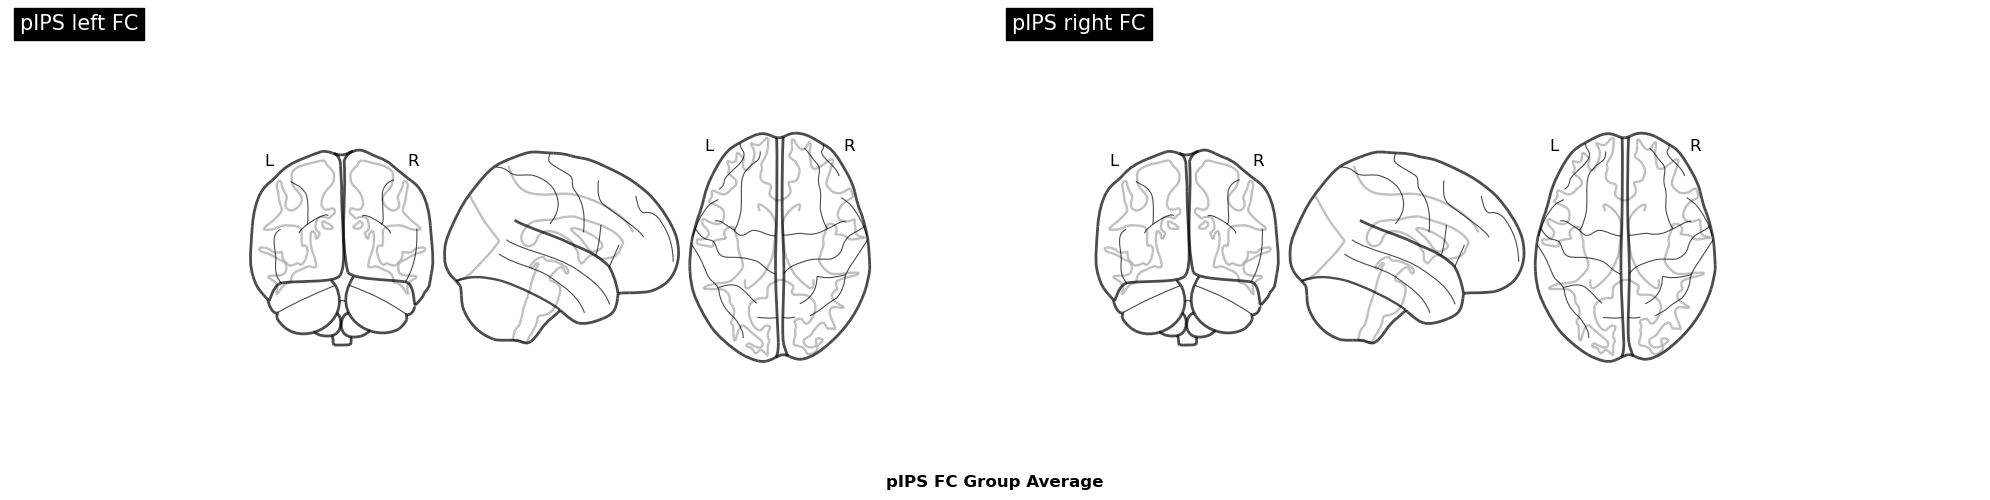

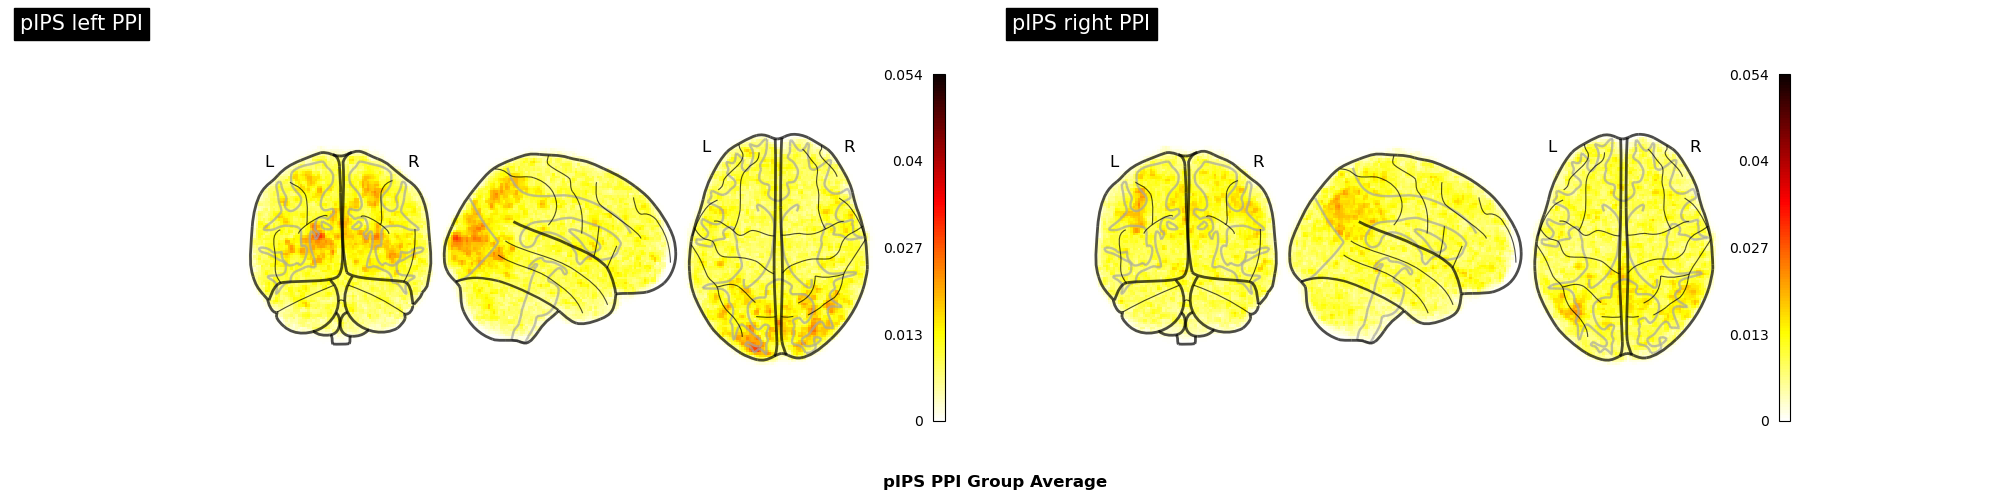

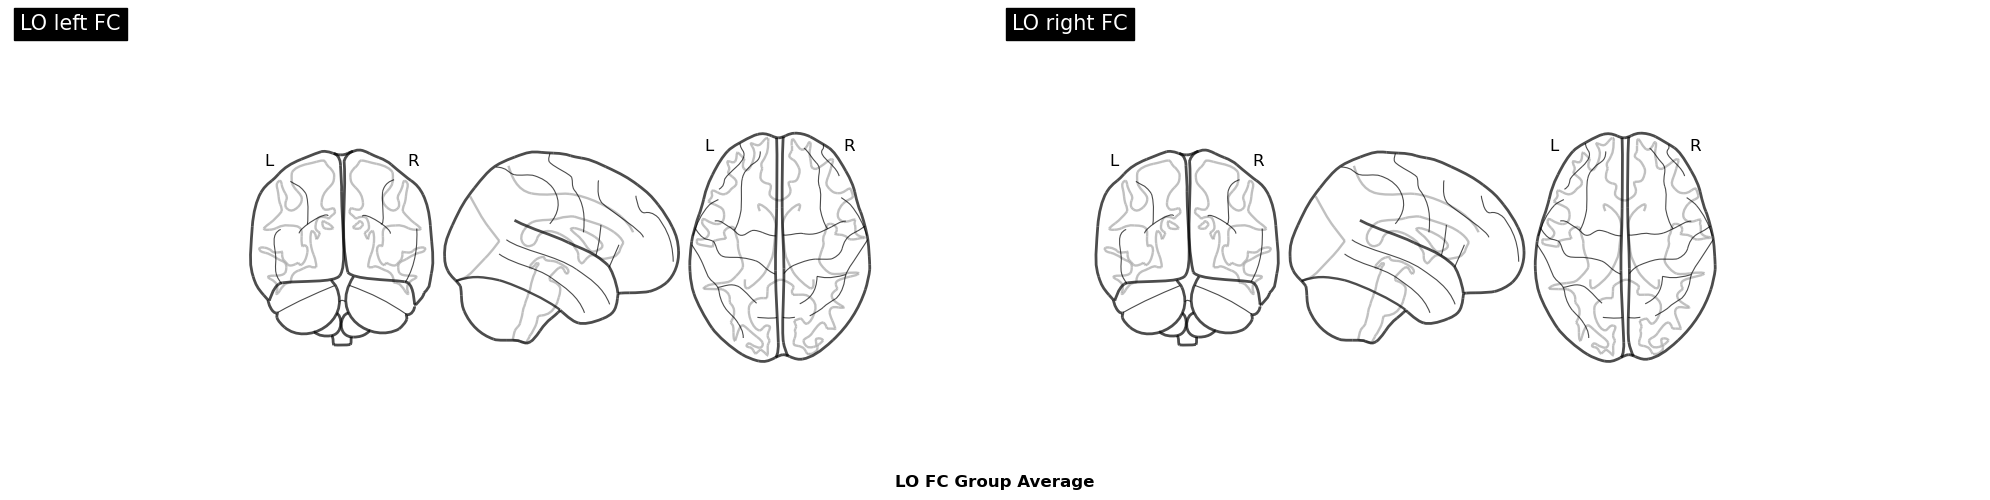

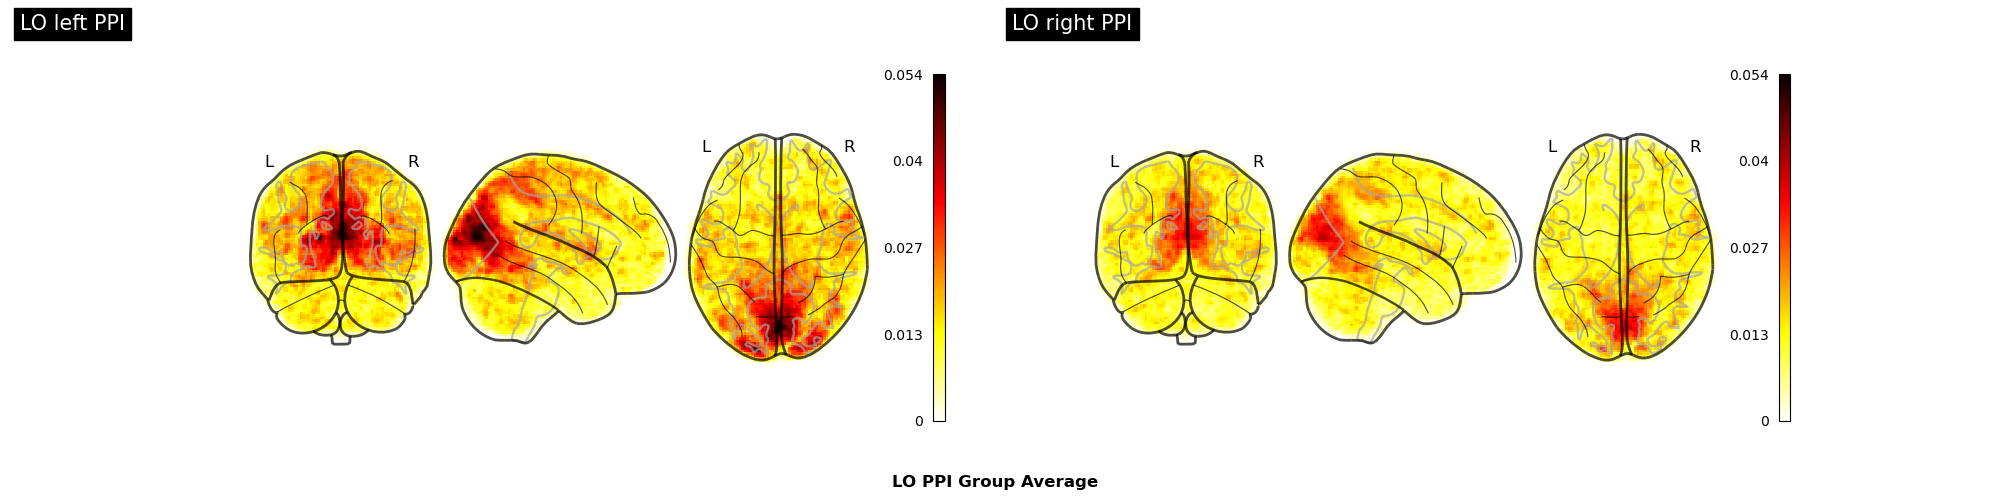

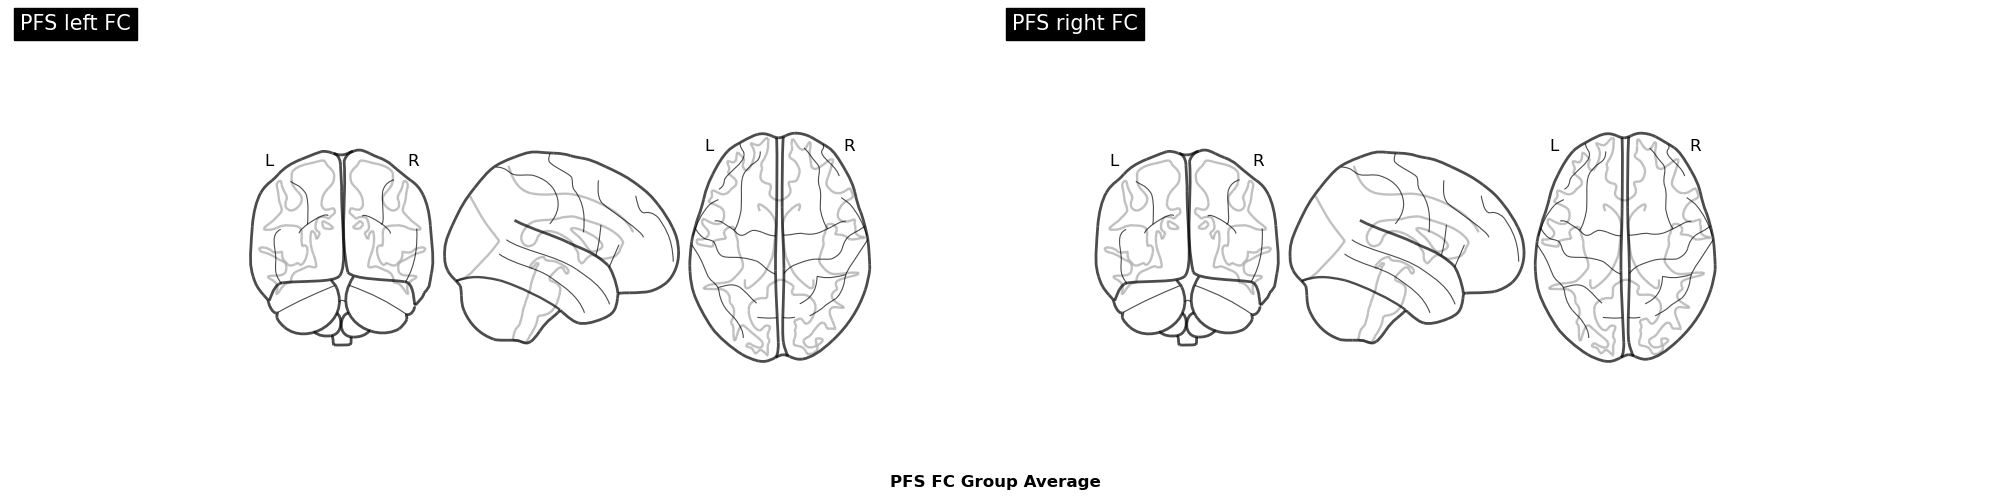

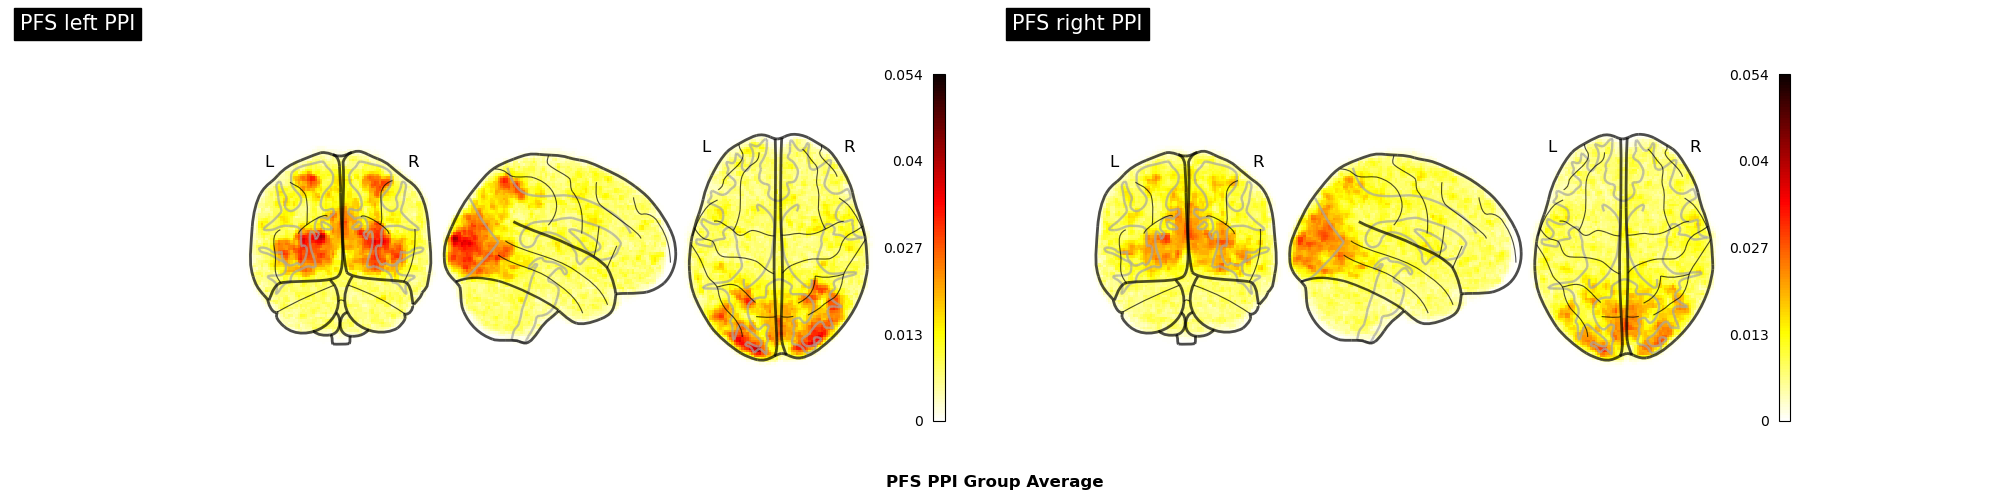

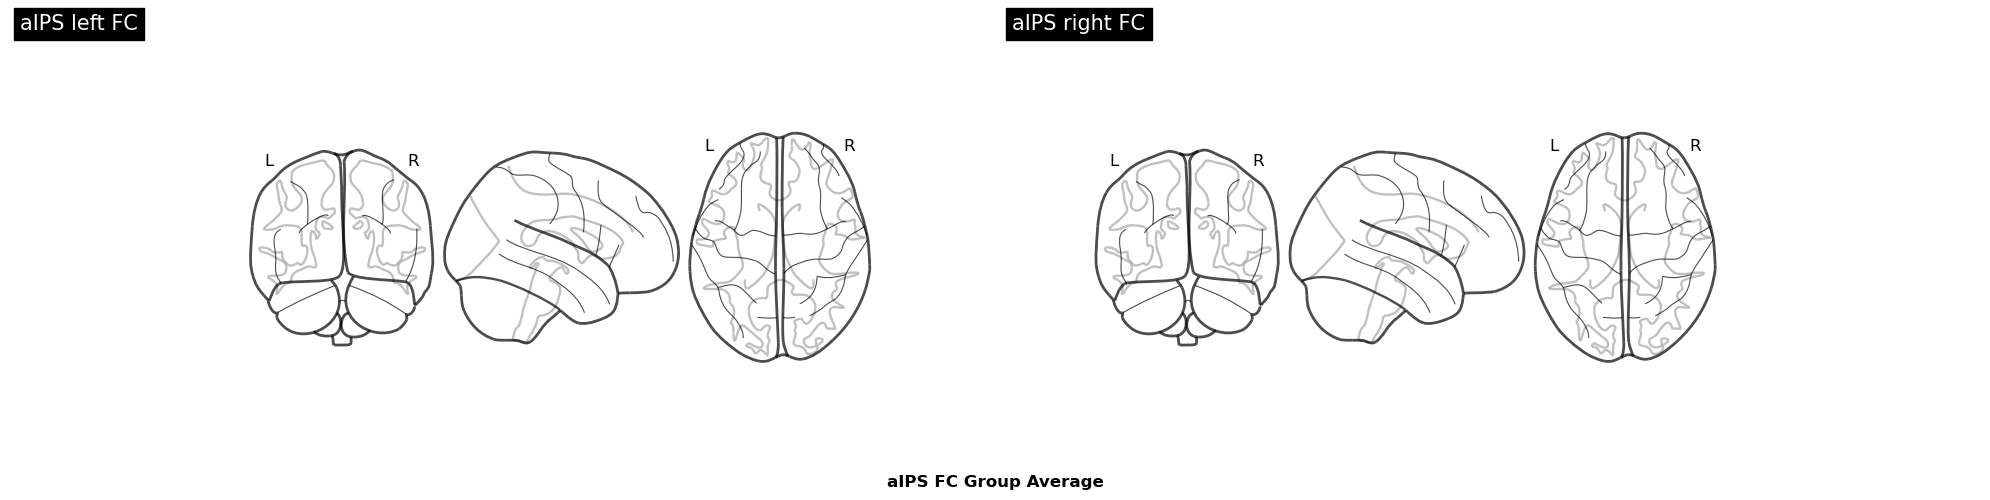

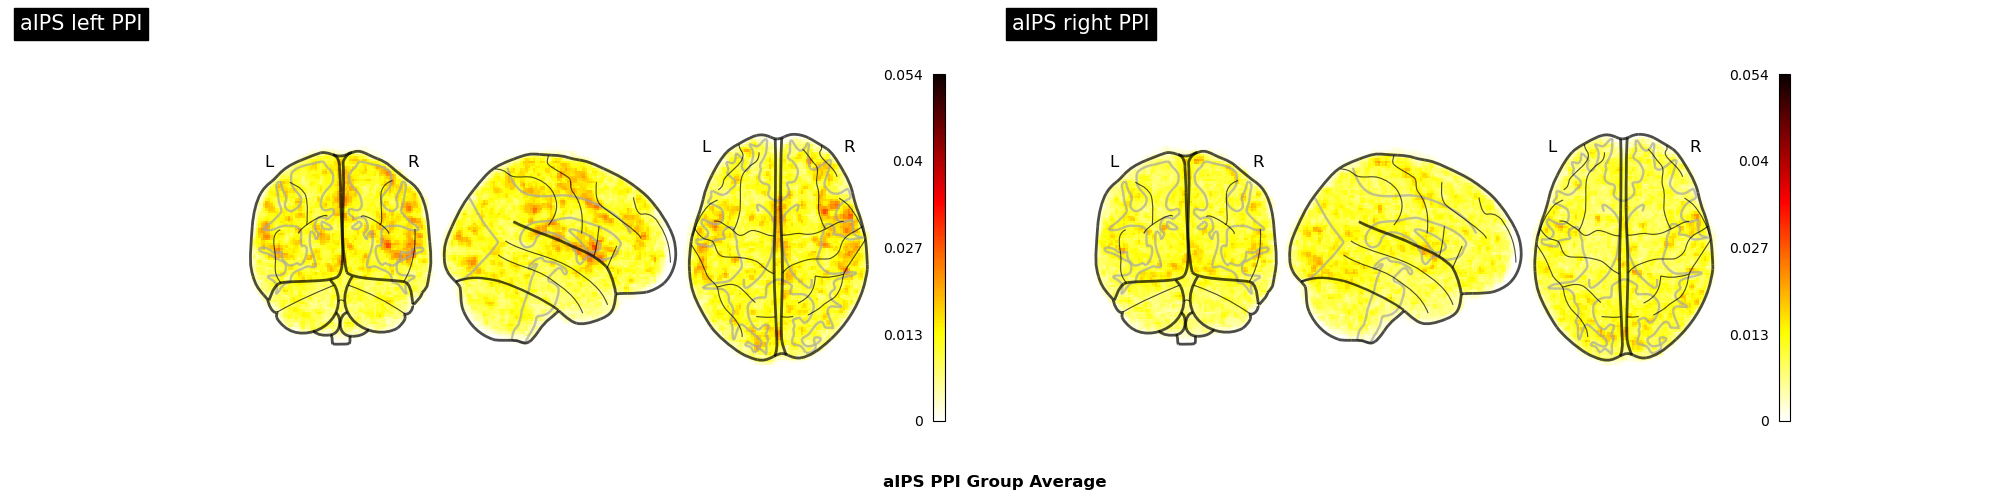

In [7]:
## group average with hemisphere tool
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
curr_dir = '/user_data/csimmon2/git_repos/ptoc'

# Explicitly set the path to sub_info.csv
sub_info_path = f'{curr_dir}/sub_info_tool.csv'

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'LO', 'PFS', 'aIPS']
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    # Construct path for each subject's file
                    img_file = f"{study_dir}/{sub}/ses-01/derivatives/fc/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz"
                    
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    # Create and save average image if files were found
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Successfully saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # Calculate separate max values for FC and PPI
    fc_max = 0
    ppi_max = 0
    
    # Find maximum values across all ROIs and hemispheres
    for roi in rois:
        for hemi in hemispheres:
            # Get FC max
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                fc_max = max(fc_max, np.abs(data).max())
            
            # Get PPI max
            img_file = f'{out_dir}/{roi}_{hemi}_ppi_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                ppi_max = max(ppi_max, np.abs(data).max())

    # Create plots for each ROI
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Set max value and threshold based on analysis type
            if analysis_type == 'fc':
                vmax = fc_max
                threshold = 0.2
            else:
                vmax = ppi_max
                threshold = 0 #0.012
            
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=threshold,
                        colorbar=True,
                        vmax=vmax, 
                        vmin=-vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i],
                        display_mode='ortho'
                    )
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            #plt.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close()

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    #os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

/tmp/ipykernel_12682/921810196.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


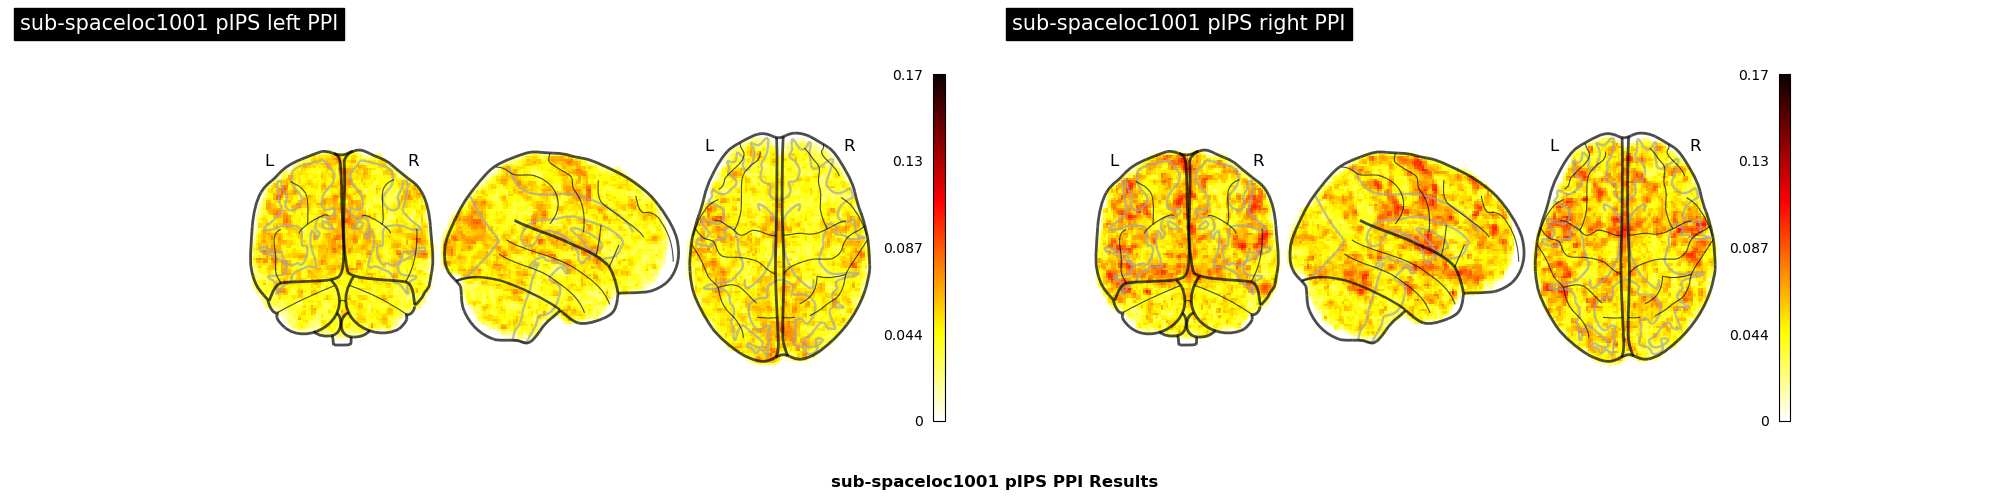

KeyboardInterrupt: 

In [1]:
# individual plots no fc and no averaging.
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
curr_dir = '/user_data/csimmon2/git_repos/ptoc'

# Explicitly set the path to sub_info.csv
sub_info_path = f'{curr_dir}/sub_info_tool.csv'

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'aIPS']
hemispheres = ['left', 'right']

def plot_individual_ppi(subs, rois, hemispheres):
    # Find maximum value across all subjects for consistent scaling
    ppi_max = 0
    for sub in subs:
        for roi in rois:
            for hemi in hemispheres:
                img_file = f"{study_dir}/{sub}/ses-01/derivatives/fc/{sub}_{roi}_{hemi}_ToolLoc_ppi_mni.nii.gz"
                if os.path.exists(img_file):
                    data = nib.load(img_file).get_fdata()
                    ppi_max = max(ppi_max, np.abs(data).max())

    # Plot each subject's PPI results
    for sub in subs:
        for roi in rois:
            # Create a figure with subplots for left and right hemispheres
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            for i, hemi in enumerate(hemispheres):
                img_file = f"{study_dir}/{sub}/ses-01/derivatives/fc/{sub}_{roi}_{hemi}_ToolLoc_ppi_mni.nii.gz"
                
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file,
                        threshold=0,  # You can adjust this threshold as needed
                        colorbar=True,
                        vmax=ppi_max,
                        vmin=-ppi_max,
                        title=f'{sub} {roi} {hemi} PPI',
                        axes=axes[i],
                        display_mode='ortho'
                    )
                else:
                    print(f"Warning: File not found for {sub}, {roi}, {hemi}")
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{sub} {roi} PPI Results', 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            plt.show()
            plt.close()

def main():
    # Plot individual PPI results
    plot_individual_ppi(subs, rois, hemispheres)

if __name__ == "__main__":
    main()

In [2]:
# code from exp_1 - trying to troubleshoot for exp_2 || confirmed 
# Extract PPI and FC results for plotting functional connectivity
# create csv of seed target activations
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()

rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
analyses = ['fc', 'ppi']
tasks = ['loc']

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def process_subjects():
    results = []
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # Load ROI coordinates
        roi_dir = f'{study_dir}/{subject}/ses-01/derivatives/rois'
        roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords_hemisphere.csv')
        
        # Create ROI maskers for target ROIs (LO)
        target_maskers = {}
        for hemisphere in hemispheres:
            for task in tasks:
                curr_coords = roi_coords[
                    (roi_coords['task'] == task) & 
                    (roi_coords['roi'] == 'LO') &
                    (roi_coords['hemisphere'] == hemisphere)
                ]
                
                if curr_coords.empty:
                    print(f"No coordinates found for {subject}, LO, {hemisphere}, {task}")
                    continue
                
                coords = curr_coords[['x', 'y', 'z']].values.tolist()[0]
                target_maskers[(hemisphere, task)] = create_roi_masker(coords)
        
        # Process each analysis
        for analysis in analyses:
            results_dir = os.path.join(study_dir, subject, 'ses-01', 'derivatives', 'fc')
            
            # Use pIPS as seed
            for seed_hemisphere in hemispheres:
                for task in tasks:
                    seed_file = f"{subject}_pIPS_{seed_hemisphere}_{task}_{analysis}.nii.gz"
                    full_seed_path = os.path.join(results_dir, seed_file)
                    
                    if not os.path.exists(full_seed_path):
                        print(f"No {analysis} results file found for {subject}, pIPS, {seed_hemisphere}, {task}")
                        continue
                    
                    # Load the seed results image
                    seed_img = nib.load(full_seed_path)
                    
                    # Extract mean activation in target ROIs (LO)
                    for target_hemisphere in hemispheres:
                        target_masker = target_maskers.get((target_hemisphere, task))
                        if target_masker is None:
                            print(f"No target masker found for {subject}, LO, {target_hemisphere}, {task}")
                            continue
                        
                        # Extract mean activation
                        mean_activation = extract_mean_activation(seed_img, target_masker)
                        
                        # Store the results
                        results.append({
                            'subject': subject,
                            'seed_roi': 'pIPS',
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Save the results to a CSV file
    output_file = os.path.join(results_dir, 'matchvlad_seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Run the processing
if __name__ == "__main__":
    process_subjects()

Processing subject: sub-025
Processing subject: sub-038
Processing subject: sub-057
Processing subject: sub-059
Processing subject: sub-064
Processing subject: sub-067
Processing subject: sub-068
Processing subject: sub-071
Processing subject: sub-083
Processing subject: sub-084
Processing subject: sub-085
Processing subject: sub-087
Processing subject: sub-088
Processing subject: sub-093
Processing subject: sub-094
Processing subject: sub-095
Processing subject: sub-096
Processing subject: sub-097
Processing subject: sub-107
Results saved to /lab_data/behrmannlab/vlad/ptoc/sub-107/ses-01/derivatives/fc/matchvlad_seed_target_activations.csv


In [8]:
## np use output summary instead of this? Rerun after rerunning fc_ppi and change paths. output summary is with full parcels. 
# Extract PPI results for pIPS to LO connectivity in native space - this uses the 6 mm sphere ROIs || I think we need to connect to the full parcel ROIs
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

hemispheres = ['left', 'right']
analysis = 'ppi'
task = 'ToolLoc'
condition = 'tools'  # Explicitly using tools condition

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def get_roi_coordinates(roi_coords, subject, hemisphere, roi_base, condition):
    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
    roi_name = f"{hemi_prefix}{roi_base}"
    
    curr_coords = roi_coords[
        (roi_coords['subject'] == subject) &
        (roi_coords['task'] == task) &
        (roi_coords['condition'] == condition) &
        (roi_coords['roi'] == roi_name)
    ]
    
    if curr_coords.empty:
        return None
    return curr_coords[['x', 'y', 'z']].values.tolist()[0]

def process_subjects():
    results = []
    
    # Load centralized ROI coordinates
    roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # First, get LO target coordinates for both hemispheres
        lo_maskers = {}
        for target_hemisphere in hemispheres:
            lo_coords = get_roi_coordinates(roi_coords, subject, target_hemisphere, 'LO', condition)
            
            if lo_coords is None:
                print(f"No LO coordinates found for {subject}, {target_hemisphere}, {condition}")
                continue
                
            lo_maskers[target_hemisphere] = create_roi_masker(lo_coords)
        
        # Now process pIPS seeds
        for seed_hemisphere in hemispheres:
            # Using native space images (removed _mni suffix)
            seed_file = f"{subject}_pIPS_{seed_hemisphere}_{task}_{analysis}.nii.gz"
            full_seed_path = os.path.join(study_dir, f"{subject}", 'ses-01', 'derivatives', 'fc', seed_file)
            
            if not os.path.exists(full_seed_path):
                print(f"No PPI results file found for {subject}, pIPS, {seed_hemisphere}")
                continue
            
            try:
                seed_img = nib.load(full_seed_path)
            except Exception as e:
                print(f"Error loading seed image for {subject}, pIPS, {seed_hemisphere}: {e}")
                continue
            
            # Extract connectivity with each LO target
            for target_hemisphere, lo_masker in lo_maskers.items():
                try:
                    mean_activation = extract_mean_activation(seed_img, lo_masker)
                    
                    results.append({
                        'subject': subject,
                        'seed_roi': 'pIPS',
                        'seed_hemisphere': seed_hemisphere,
                        'target_roi': 'LO',
                        'target_hemisphere': target_hemisphere,
                        'task': task,
                        'analysis': analysis,
                        'mean_activation': mean_activation
                    })
                except Exception as e:
                    print(f"Error extracting activation for {subject}, {target_hemisphere} LO: {e}")
                    continue
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    output_file = os.path.join(results_dir, 'seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
Processing subject: sub-spaceloc1002
Processing subject: sub-spaceloc1003
Processing subject: sub-spaceloc1004
Processing subject: sub-spaceloc1005
Processing subject: sub-spaceloc1006
Processing subject: sub-spaceloc1007
Processing subject: sub-spaceloc1008
Processing subject: sub-spaceloc1009
Processing subject: sub-spaceloc1010
Processing subject: sub-spaceloc1011
Processing subject: sub-spaceloc1012
Processing subject: sub-spaceloc2013
Processing subject: sub-spaceloc2014
Processing subject: sub-spaceloc2015
Processing subject: sub-spaceloc2016
Processing subject: sub-spaceloc2017
Processing subject: sub-spaceloc2018
Results saved to /user_data/csimmon2/git_repos/ptoc/results/tools/seed_target_activations.csv


In [19]:
# added aIPS to the seed target activations - otherwise the same.
# Extract PPI results for pIPS to LO connectivity in native space - this uses the 6 mm sphere ROIs || I think we need to connect to the full parcel ROIs
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

hemispheres = ['left', 'right']
analysis = 'ppi'
task = 'ToolLoc'
condition = 'tools'  # Explicitly using tools condition
seed_regions = ['pIPS', 'aIPS']  # Added aIPS as a seed region

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def get_roi_coordinates(roi_coords, subject, hemisphere, roi_base, condition):
    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
    roi_name = f"{hemi_prefix}{roi_base}"
    
    curr_coords = roi_coords[
        (roi_coords['subject'] == subject) &
        (roi_coords['task'] == task) &
        (roi_coords['condition'] == condition) &
        (roi_coords['roi'] == roi_name)
    ]
    
    if curr_coords.empty:
        return None
    return curr_coords[['x', 'y', 'z']].values.tolist()[0]

def process_subjects():
    results = []
    
    # Load centralized ROI coordinates
    roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # First, get LO target coordinates for both hemispheres
        lo_maskers = {}
        for target_hemisphere in hemispheres:
            lo_coords = get_roi_coordinates(roi_coords, subject, target_hemisphere, 'LO', condition)
            
            if lo_coords is None:
                print(f"No LO coordinates found for {subject}, {target_hemisphere}, {condition}")
                continue
                
            lo_maskers[target_hemisphere] = create_roi_masker(lo_coords)
        
        # Now process both pIPS and aIPS seeds
        for seed_region in seed_regions:
            for seed_hemisphere in hemispheres:
                # Using native space images
                seed_file = f"{subject}_{seed_region}_{seed_hemisphere}_{task}_{analysis}.nii.gz"
                full_seed_path = os.path.join(study_dir, f"{subject}", 'ses-01', 'derivatives', 'fc', seed_file)
                
                if not os.path.exists(full_seed_path):
                    print(f"No PPI results file found for {subject}, {seed_region}, {seed_hemisphere}")
                    continue
                
                try:
                    seed_img = nib.load(full_seed_path)
                except Exception as e:
                    print(f"Error loading seed image for {subject}, {seed_region}, {seed_hemisphere}: {e}")
                    continue
                
                # Extract connectivity with each LO target
                for target_hemisphere, lo_masker in lo_maskers.items():
                    try:
                        mean_activation = extract_mean_activation(seed_img, lo_masker)
                        
                        results.append({
                            'subject': subject,
                            'seed_roi': seed_region,
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
                    except Exception as e:
                        print(f"Error extracting activation for {subject}, {target_hemisphere} LO: {e}")
                        continue
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    output_file = os.path.join(results_dir, 'seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
Processing subject: sub-spaceloc1002
Processing subject: sub-spaceloc1003
Processing subject: sub-spaceloc1004
Processing subject: sub-spaceloc1005
Processing subject: sub-spaceloc1006
Processing subject: sub-spaceloc1007
Processing subject: sub-spaceloc1008
Processing subject: sub-spaceloc1009
Processing subject: sub-spaceloc1010
Processing subject: sub-spaceloc1011
Processing subject: sub-spaceloc1012
Processing subject: sub-spaceloc2013
Processing subject: sub-spaceloc2014
Processing subject: sub-spaceloc2015
Processing subject: sub-spaceloc2016
Processing subject: sub-spaceloc2017
Processing subject: sub-spaceloc2018
Results saved to /user_data/csimmon2/git_repos/ptoc/results/tools/seed_target_activations.csv


In [22]:
# the same as above but with parcels instead of spheres
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn import image
import sys
import time

# Import parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

hemispheres = ['left', 'right']
seeds = ['pIPS', 'aIPS']
analysis = 'ppi'
task = 'ToolLoc'
condition = 'tools'

def get_roi_path(subject, roi):
    """Get path to the anatomical parcel ROI"""
    path = os.path.join('/lab_data', 'behrmannlab', 'vlad', 'hemispace', 
                       f'{subject}', 'ses-01', 
                       'derivatives', 'rois', 'parcels',
                       f'{roi}.nii.gz')
    print(f"Attempting to access ROI at: {path}")
    if not os.path.exists(path):
        print(f"WARNING: Path does not exist: {path}")
    return path

def create_hemisphere_mask(roi_img, hemisphere):
    """Create hemisphere mask based on image dimensions, just like in extract_roi_coords"""
    # Get image data
    roi_data = roi_img.get_fdata()
    affine = roi_img.affine
    
    # Split at center of x dimension
    center_x = roi_data.shape[0] // 2
    
    # Create hemisphere mask using the same slicing approach
    hemi_data = np.zeros_like(roi_data)
    if hemisphere == 'left':
        hemi_data[:center_x] = roi_data[:center_x]
    else:  # right hemisphere
        hemi_data[center_x:] = roi_data[center_x:]
    
    # Create new image maintaining the original affine
    return nib.Nifti1Image(hemi_data, affine)

def create_hemisphere_specific_masker(roi_path, hemisphere):
    """Create a masker for one hemisphere of an ROI"""
    # Load the ROI
    roi_img = nib.load(roi_path)
    
    # Create hemisphere-specific mask
    hemi_roi = create_hemisphere_mask(roi_img, hemisphere)
    
    return NiftiMasker(mask_img=hemi_roi)

def extract_mean_activation(results_img, roi_masker):
    """Extract mean activation using the masker"""
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def process_subjects():
    results = []
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # Get LO parcel path
        lo_path = get_roi_path(subject, 'LO')
        
        if not os.path.exists(lo_path):
            print(f"No LO parcel found for {subject}")
            continue
        
        # Create hemisphere-specific maskers for LO
        lo_maskers = {}
        for target_hemisphere in hemispheres:
            try:
                lo_maskers[target_hemisphere] = create_hemisphere_specific_masker(
                    lo_path, target_hemisphere
                )
            except Exception as e:
                print(f"Error creating masker for {subject}, {target_hemisphere} LO: {e}")
                continue
        
        # Process both pIPS and aIPS seeds
        for seed in seeds:
            for seed_hemisphere in hemispheres:
                # Using native space images
                seed_file = f"{subject}_{seed}_{seed_hemisphere}_{task}_{analysis}.nii.gz"
                full_seed_path = os.path.join(study_dir, f"{subject}", 'ses-01', 
                                            'derivatives', 'fc', seed_file)
                
                if not os.path.exists(full_seed_path):
                    print(f"No PPI results file found for {subject}, {seed}, {seed_hemisphere}")
                    continue
                
                try:
                    seed_img = nib.load(full_seed_path)
                except Exception as e:
                    print(f"Error loading seed image for {subject}, {seed}, {seed_hemisphere}: {e}")
                    continue
                
                # Extract connectivity with each hemisphere's LO
                for target_hemisphere, lo_masker in lo_maskers.items():
                    try:
                        mean_activation = extract_mean_activation(seed_img, lo_masker)
                        
                        results.append({
                            'subject': subject,
                            'seed_roi': seed,
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
                    except Exception as e:
                        print(f"Error extracting activation for {subject}, {target_hemisphere} LO: {e}")
                        continue
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    output_file = os.path.join(results_dir, 'parcel_seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
Attempting to access ROI at: /lab_data/behrmannlab/vlad/hemispace/sub-spaceloc1001/ses-01/derivatives/rois/parcels/LO.nii.gz
Processing subject: sub-spaceloc1002
Attempting to access ROI at: /lab_data/behrmannlab/vlad/hemispace/sub-spaceloc1002/ses-01/derivatives/rois/parcels/LO.nii.gz
Processing subject: sub-spaceloc1003
Attempting to access ROI at: /lab_data/behrmannlab/vlad/hemispace/sub-spaceloc1003/ses-01/derivatives/rois/parcels/LO.nii.gz
Processing subject: sub-spaceloc1004
Attempting to access ROI at: /lab_data/behrmannlab/vlad/hemispace/sub-spaceloc1004/ses-01/derivatives/rois/parcels/LO.nii.gz
Processing subject: sub-spaceloc1005
Attempting to access ROI at: /lab_data/behrmannlab/vlad/hemispace/sub-spaceloc1005/ses-01/derivatives/rois/parcels/LO.nii.gz
Processing subject: sub-spaceloc1006
Attempting to access ROI at: /lab_data/behrmannlab/vlad/hemispace/sub-spaceloc1006/ses-01/derivatives/rois/parcels/LO.nii.gz
Processing subject: sub-spac

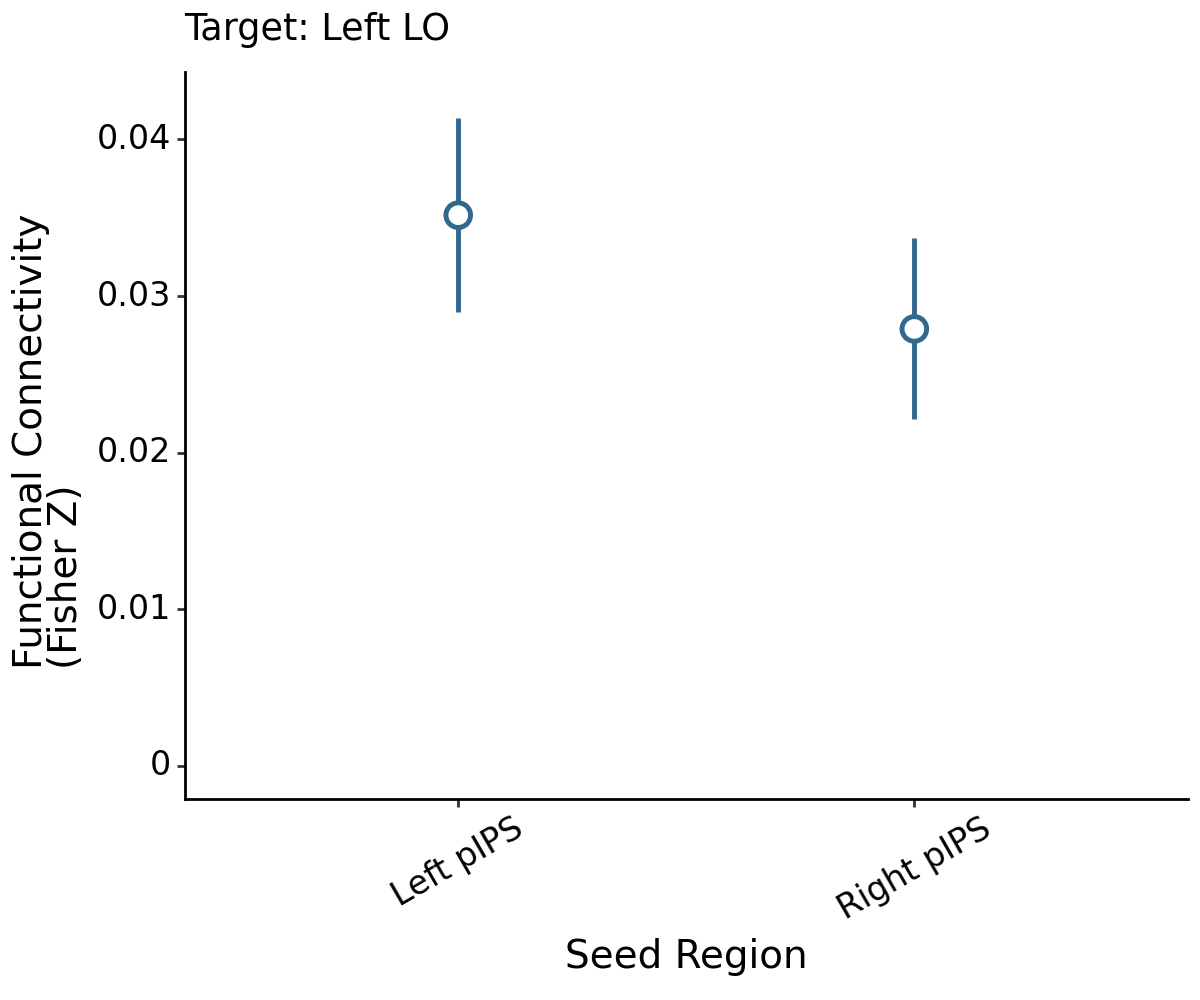

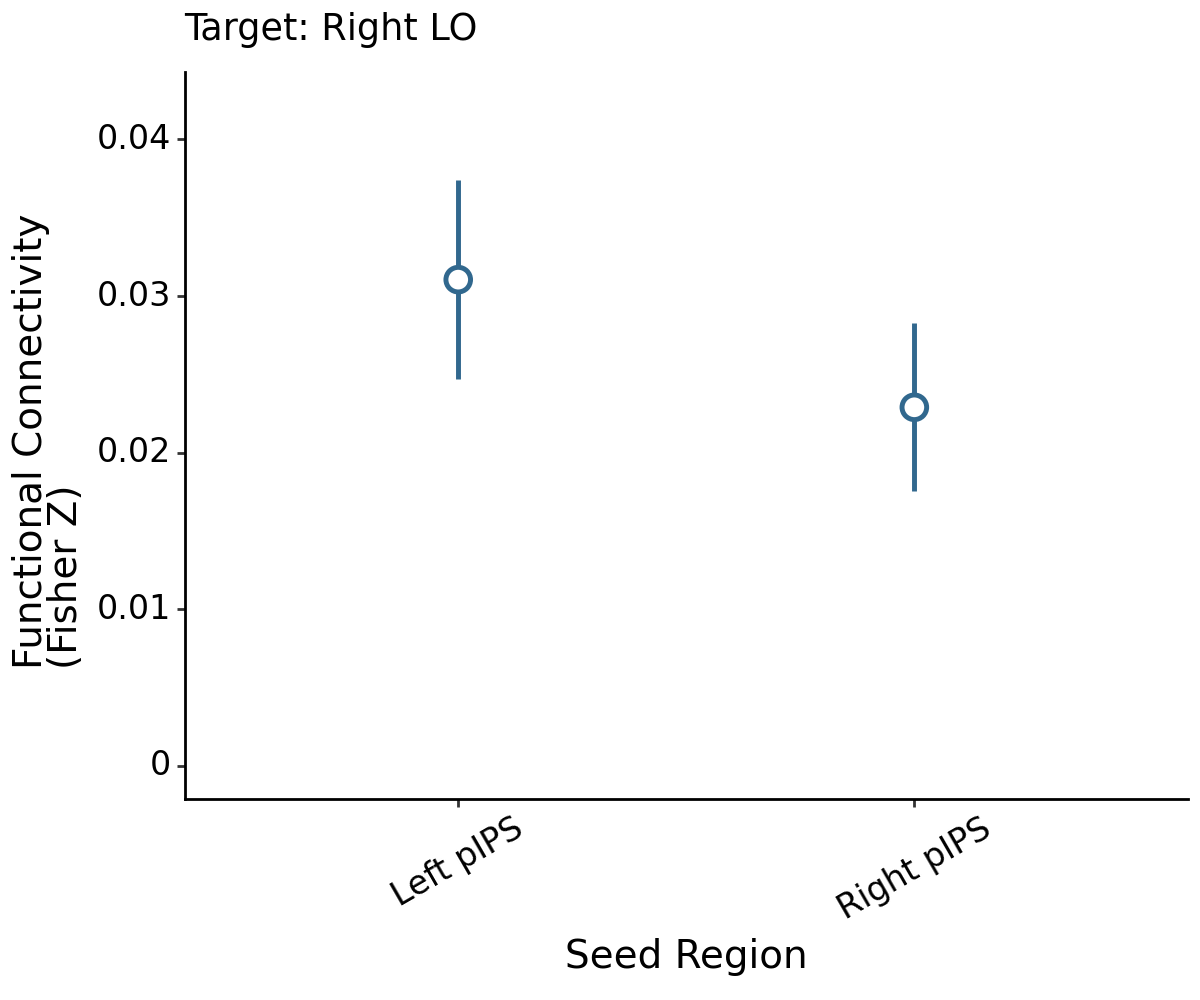

In [2]:
# code from exp_1 - trying to troubleshoot for exp_2 || confirmed
# code for plotting statistical results.
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, scale_color_manual, theme, element_text, element_line, element_blank, facet_wrap, ggtitle

# Define variables
analysis = 'ppi'#'fc'
#analysis = 'fc'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'ppi')]
#df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'fc')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Function to create plot for a specific target
def create_plot(data, target):
    plot = (ggplot(data[data['Target'] == target], aes(x='Seed', y='FC', color='LOC'))
            + geom_linerange(aes(ymax='FC + SE', ymin='FC - SE'), size=1)
            + geom_point(shape='o', size=4, fill='white', stroke=1)
            + ylim(0, data['FC'].max() * 1.2)  # Adjust ylim based on data
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity \n(Fisher Z)')
            + scale_color_manual(values=['#31688E'])
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(6, 5)
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
left_lo_plot = create_plot(summary_df, 'Left LO')
right_lo_plot = create_plot(summary_df, 'Right LO')

print(left_lo_plot)
print(right_lo_plot)

# Optionally, save the plots
left_lo_plot.save("left_lo_ppi_plot.png", dpi=300)
right_lo_plot.save("right_lo_ppi_plot.png", dpi=300)


Data for plotting (including error bar limits):
      Seed   Target       FC       SE      ymin     ymax
 left_pIPS  left_LO 0.012220 0.005272  0.006949 0.017492
 left_pIPS right_LO 0.014129 0.004765  0.009364 0.018894
right_pIPS  left_LO 0.000728 0.003281 -0.002553 0.004008
right_pIPS right_LO 0.004227 0.004251 -0.000023 0.008478

Left LO Plot:


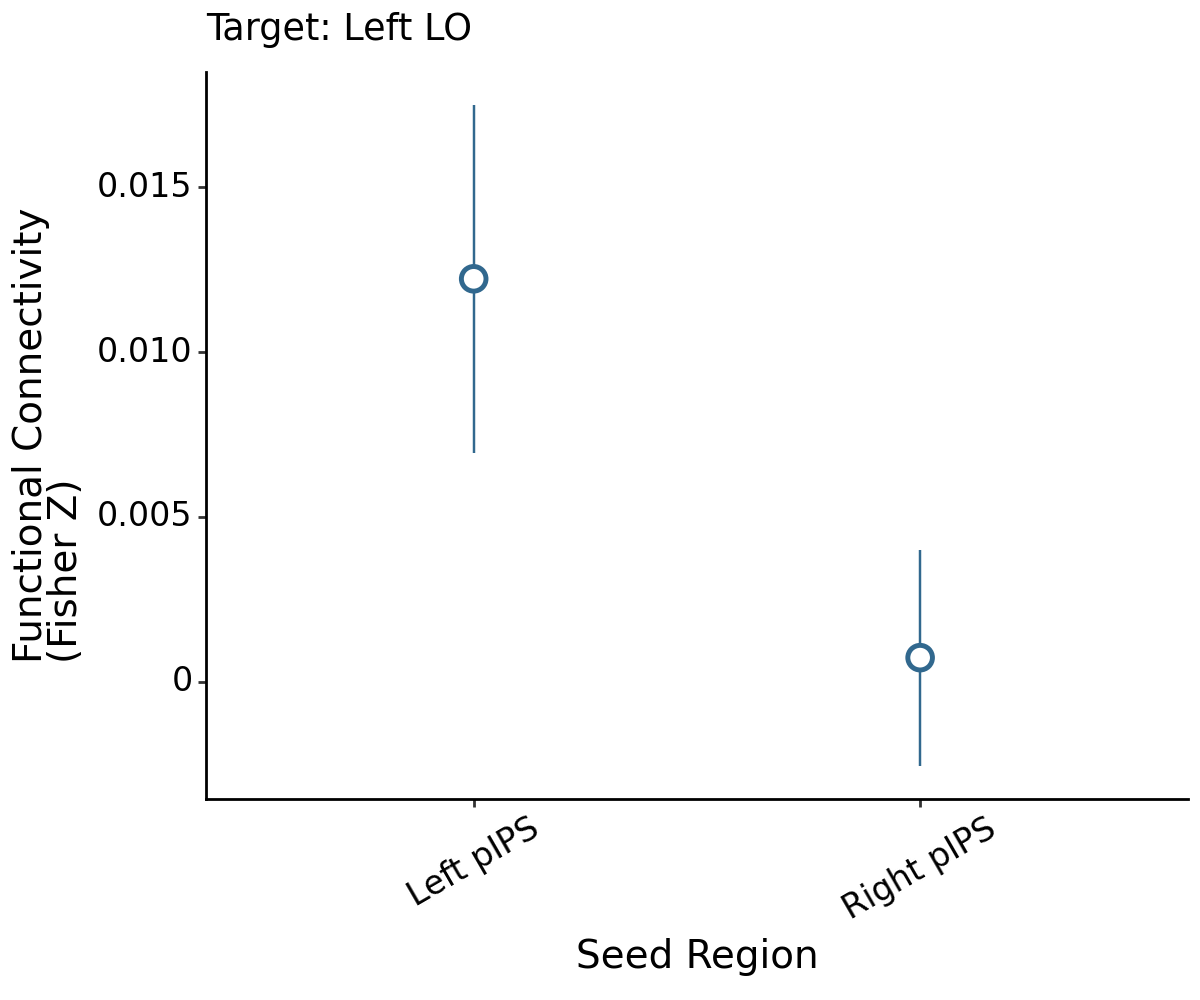



Right LO Plot:


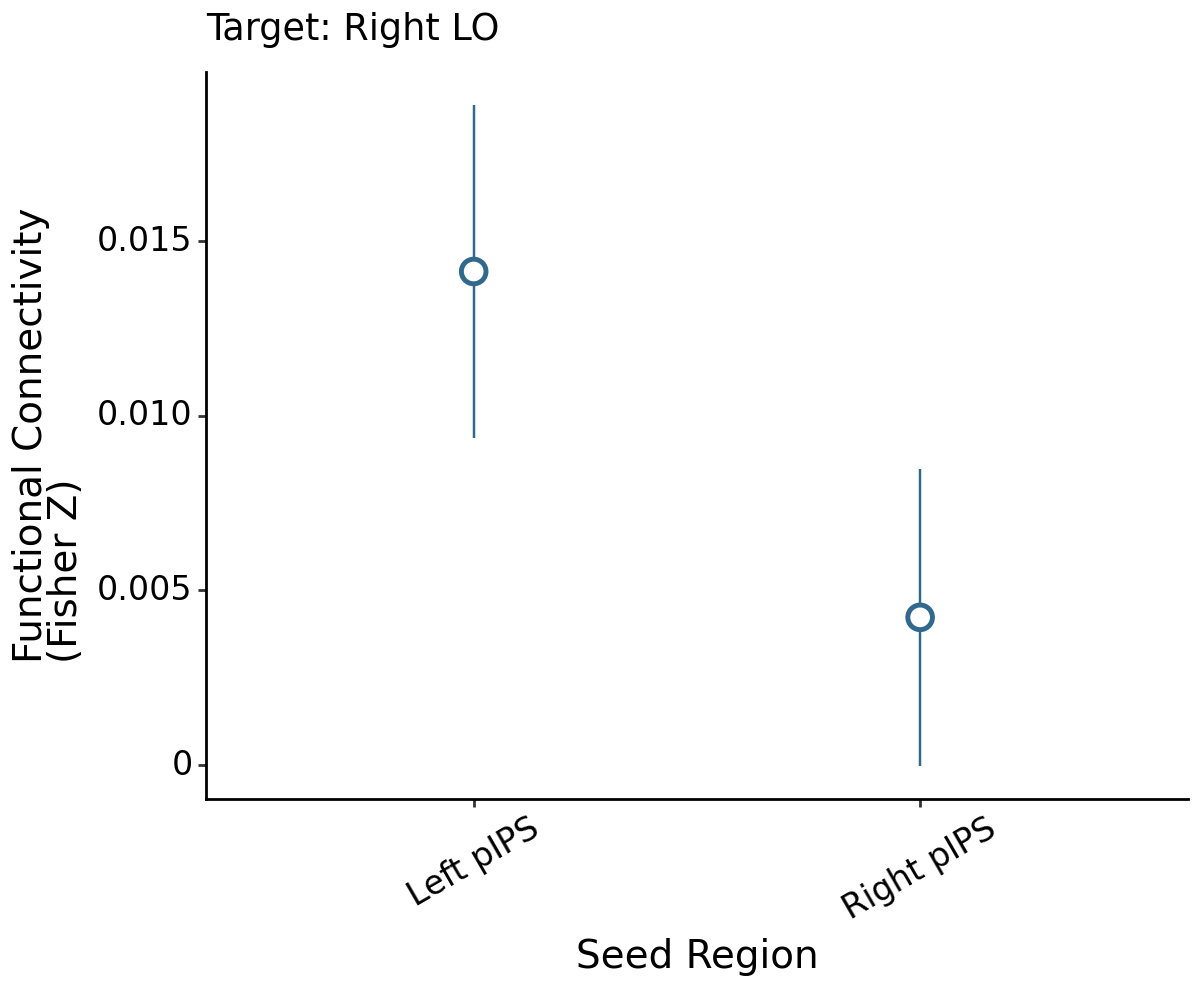

In [18]:
# plotting tool functional connectivity - the reason it's so much lower than objects, if you pull of the ppi results there is minimal connectivity between the rpIPS and either LO
## one potential concern of mine is that a 6 mm roi is misleading to demonstrate the pips to lo connectivity. It may make more sense to use the full LO parcel. . . The lack of visible error bars is due to the size of the standard errors.
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, theme, element_text, element_line, element_blank, ggtitle

# Define variables
analysis = 'ppi'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'

# Read the data
df = pd.read_csv(f"{results_dir}/seed_target_activations.csv")

# Filter for the ToolLoc task and ppi analysis
df_filtered = df[(df['task'] == 'ToolLoc') & (df['analysis'] == 'ppi')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Calculate error bar limits explicitly
summary_df['ymin'] = summary_df['FC'] - summary_df['SE']
summary_df['ymax'] = summary_df['FC'] + summary_df['SE']

# Print the data to verify calculations
print("\nData for plotting (including error bar limits):")
print(summary_df.to_string(index=False))

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

def create_plot(data, target):
    # Create plot with explicit error bars
    plot = (ggplot(data[data['Target'] == target])
            + geom_linerange(aes(x='Seed', ymin='ymin', ymax='ymax'), size=.5, color='#31688E')
            + geom_point(aes(x='Seed', y='FC'), shape='o', size=4, fill='white', color='#31688E', stroke=1)
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity\n(Fisher Z)')
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(6, 5)
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
print("\nLeft LO Plot:")
print(create_plot(summary_df, 'Left LO'))
print("\nRight LO Plot:")
print(create_plot(summary_df, 'Right LO'))


Left LO Plot:


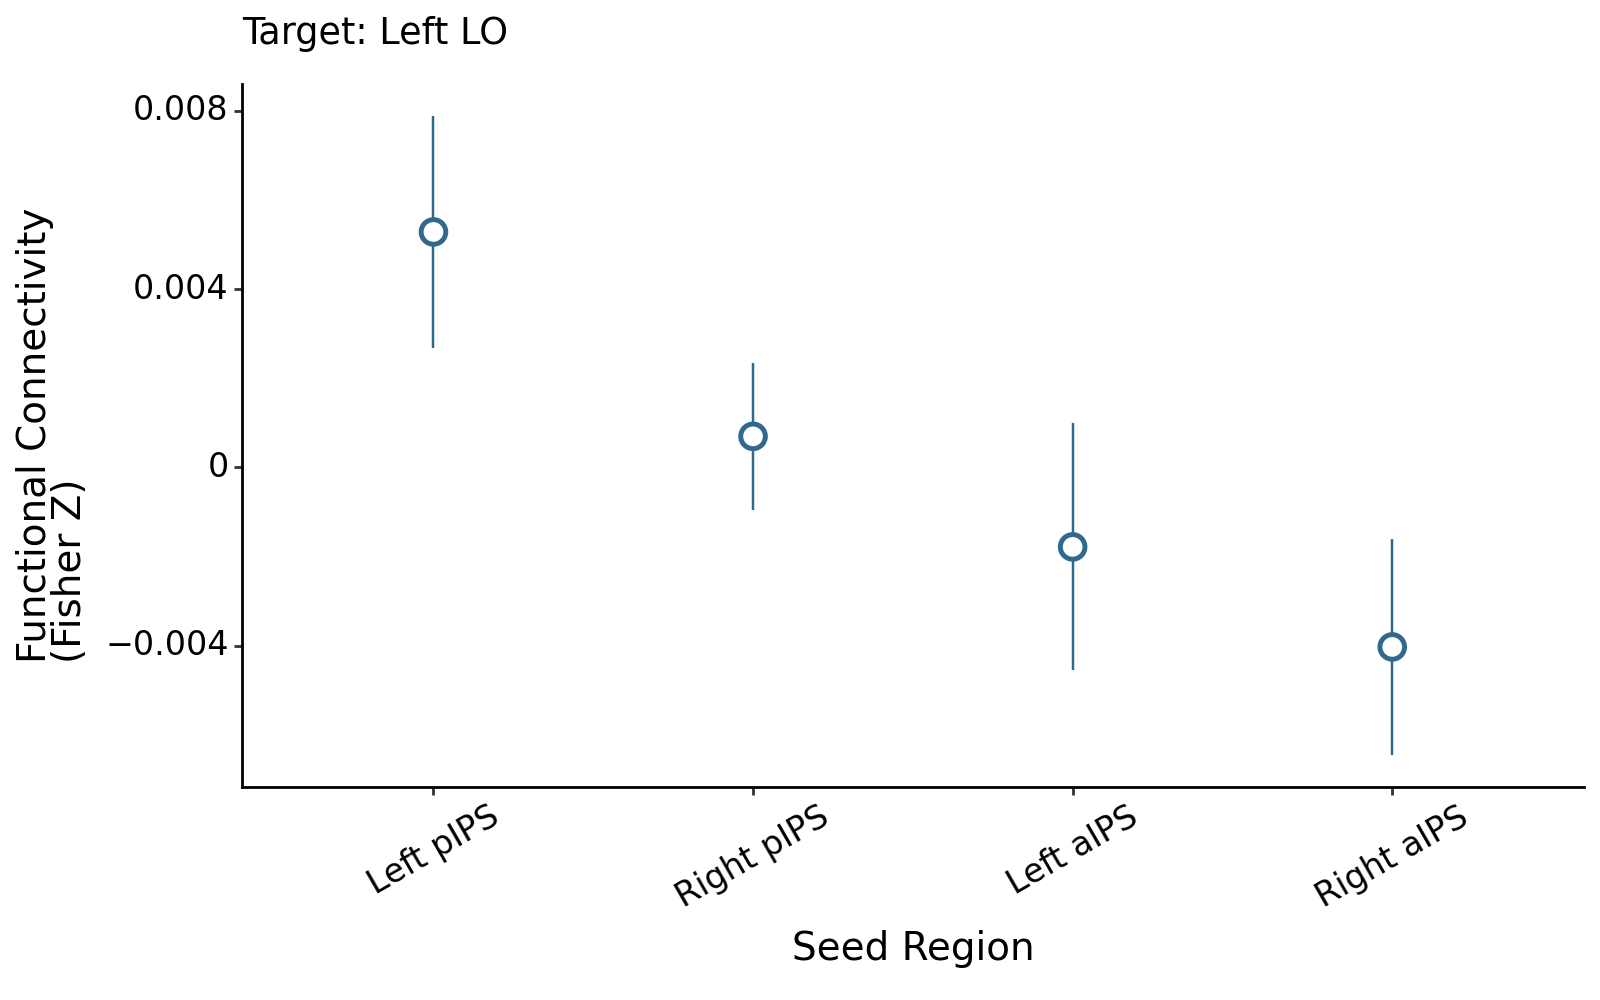



Right LO Plot:


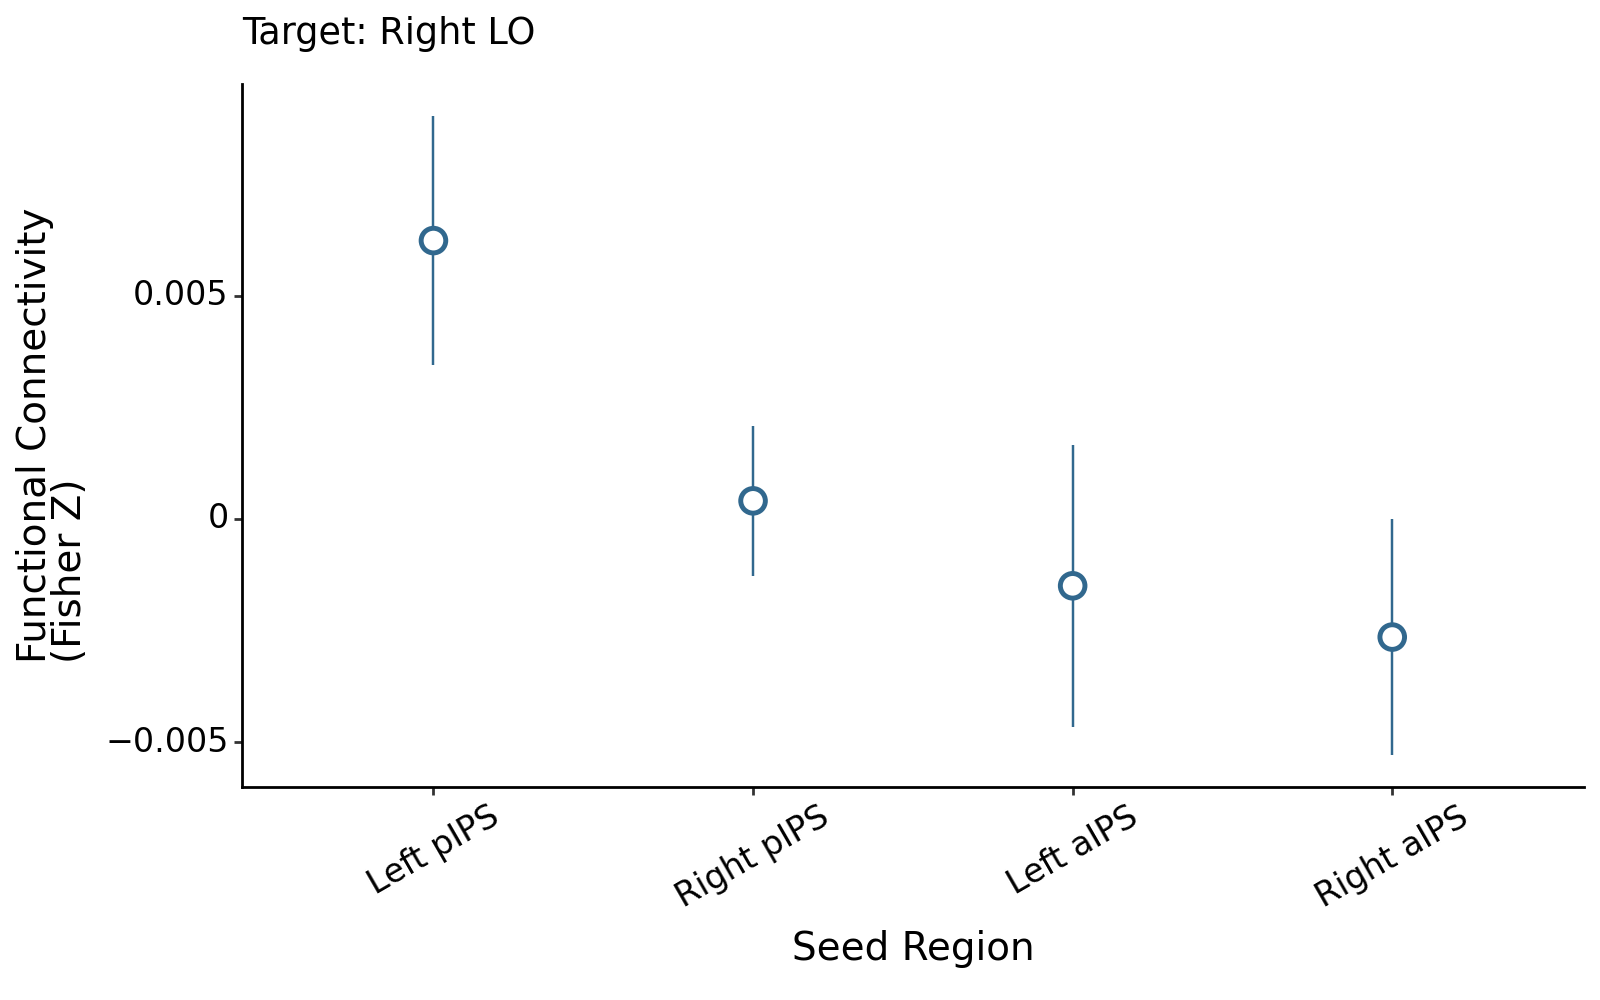

In [11]:
# add aIPS to the plots || plots full LO parcel average
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, theme, element_text, element_line, element_blank, ggtitle

# Define variables
analysis = 'ppi'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'

# Read the data
df = pd.read_csv(f"{results_dir}/parcel_seed_target_activations.csv")

# Filter for the ToolLoc task and ppi analysis
df_filtered = df[(df['task'] == 'ToolLoc') & (df['analysis'] == 'ppi')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Calculate error bar limits explicitly
summary_df['ymin'] = summary_df['FC'] - summary_df['SE']
summary_df['ymax'] = summary_df['FC'] + summary_df['SE']

# Updated seed mapping to include aIPS
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS',
    'left_aIPS': 'Left aIPS',
    'right_aIPS': 'Right aIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical with updated order
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], 
                                  categories=['Left pIPS', 'Right pIPS', 'Left aIPS', 'Right aIPS'], 
                                  ordered=False)

def create_plot(data, target):
    # Create plot with explicit error bars
    plot = (ggplot(data[data['Target'] == target])
            + geom_linerange(aes(x='Seed', ymin='ymin', ymax='ymax'), size=.5, color='#31688E')
            + geom_point(aes(x='Seed', y='FC'), shape='o', size=4, fill='white', color='#31688E', stroke=1)
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity\n(Fisher Z)')
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(8, 5)  # Increased width to accommodate more seed regions
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
print("\nLeft LO Plot:")
print(create_plot(summary_df, 'Left LO'))
print("\nRight LO Plot:")
print(create_plot(summary_df, 'Right LO'))